In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt


# # NLTK resources
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

Here's the column description:

'Username' = The Username

'PostID' = an ID string like 'kl6440' that corresponds directly to the individual post regardless of whether it is a submission or comment.

'Type' = 'Submission' or 'Comment'

'Title' = If the post was a submission to a subreddit it has a 'title'. Comments do not have a title field. All rows with 'type'= comment will have a null value in the 'Title' field.

'Content' = the body text of that row's Submission or Comment

'ContentTimestamp' = timestamp of that row's Submission or Comment

'RelatedSubmissionID' = an ID string that connects to the submission that the relevant post is connected to. For submissions this is the same as the PostID (because it is connected to itself) but for comments this provides the submission that started the thread that the comment is contained within. This is different from the parentID (see below) because RelatedSubmissionID points to the top of a comment tree, while the parentID points to whatever the comment was actually replying to.

'ParentID' = an ID string that points to the comment or submission that a comment was actually replying to. Only comments will have ParentIDs. Submissions cannot have ParentIDs.

IsSubmitter = TRUE/FALSE. Indicates if the user is commenting on their own submission chain. All 'submissions' will be FALSE. If this row is TRUE it means that the comment is in a thread that the user started.

'ContentSubreddit' = the name of the subreddit that the Submission or Comment was posted in.

'Upvotes' = number of upvotes that Submission or Comment recieved across it's livespan. Note that we do not have information about WHEN the upvotes were recieved. # Also, this can be a negative number. It includes a sum of upvotes and downvotes.

'SurveyCommentID' = an ID string that points to the survey response.

'SurveyResponse' = actual response from users to the survey Qs.

'SurveyTimestamp' = timestamp of the survey response.

'QuestionID' = 1 or 2. The survey question that the user responded to. 1 = Short-term happiness metric (Subjective Wellbeing). 2 = long-term happiness metric (Life Satisfaction).

'Score' = the value 1-10 that the user provided to the survey Q1 or Q2.


In [ ]:
# Load the data
df = pd.read_csv("RedditDataUTF-8.csv")

# Initial data inspection
print(f"Total rows in the dataset: {df.shape}")
print("Columns in the dataset:", df.columns.tolist())

# Separate data for Q1 and Q2
df_q1 = df[df['QuestionID'] == 'Q1']
df_q2 = df[df['QuestionID'] == 'Q2']

print(f"\nQ1. How happy are you right now? (Short-term happiness question): {df_q1.shape}")
unique_usernames_q1 = df_q1['Username'].nunique()
print(f"Number of unique usernames in df_q1: {unique_usernames_q1}")

print(f"\nQ2. How satisfied are you with your life? (Long-term satisfaction question): {df_q2.shape}")
unique_usernames_q2 = df_q2['Username'].nunique()
print(f"Number of unique usernames in df_q2: {unique_usernames_q2}")

Total rows in the dataset: (375947, 16)
Columns in the dataset: ['Username', 'PostID', 'Type', 'Title', 'Content', 'ContentTimestamp', 'RelatedSubmissionID', 'ParentID', 'IsSubmitter', 'ContentSubreddit', 'Upvotes', 'SurveyCommentID', 'SurveyResponse', 'SurveyTimestamp', 'QuestionID', 'Score']

Q1. How happy are you right now? (Short-term happiness question): (191001, 16)
Number of unique usernames in df_q1: 539

Q2. How satisfied are you with your life? (Long-term satisfaction question): (184946, 16)
Number of unique usernames in df_q2: 453

Note by Richard:
This data is incomplete. Will update ASAP. df_q2 will remain the same. df_q1 should end up having slightly more respondents than df_q2.


In [ ]:
# 1. Show first few records of the dataset
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,Username,PostID,Type,Title,Content,ContentTimestamp,RelatedSubmissionID,ParentID,IsSubmitter,ContentSubreddit,Upvotes,SurveyCommentID,SurveyResponse,SurveyTimestamp,QuestionID,score
0,sanjay_i,kl6440,submission,ASP.Net Core Web API: How do you deal with cli...,So I have an endpoint which returns many field...,12/27/2020 10:09,kl6440,NaN,False,csharp,17,g5hdgfr,-10,9/16/2020 11:01,Q2,1.0
1,sanjay_i,ju68zu,submission,How to make sure only the username of Authoriz...,"Hi Guys,\n\nI am a new to Authentication and A...",11/14/2020 12:06,ju68zu,NaN,False,dotnet,2,g5hdgfr,-10,9/16/2020 11:01,Q2,1.0
2,sanjay_i,ju68nr,submission,How to make sure only the username of Authoriz...,"Hi Guys,\n\nI am a new to Authentication and A...",11/14/2020 12:06,ju68nr,NaN,False,csharp,1,g5hdgfr,-10,9/16/2020 11:01,Q2,1.0
3,sanjay_i,ju689l,submission,How to make sure only the username of Authoriz...,"Hi Guys,\n\nI am a new to Authentication and A...",11/14/2020 12:05,ju689l,NaN,False,aspnetcore,0,g5hdgfr,-10,9/16/2020 11:01,Q2,1.0
4,sanjay_i,gwkzff,submission,What are the best practices to version control...,My company has more than 30 micro services. Ea...,6/4/2020 11:39,gwkzff,NaN,False,csharp,8,g5hdgfr,-10,9/16/2020 11:01,Q2,1.0


In [ ]:
# Ensure 'Score' column is of numeric type
df['Score'] = pd.to_numeric(df['Score'], errors='coerce')

# Descriptive statistics for the entire dataset
print("\nDescriptive statistics for 'Score' in the entire dataset:")
print(df['Score'].describe())


Descriptive statistics for 'Score' in the entire dataset:
count    375947.000000
mean          5.427699
std           2.494393
min           1.000000
25%           4.000000
50%           6.000000
75%           7.000000
max          10.000000
Name: Score, dtype: float64


In [ ]:
# Descriptive statistics for Q1
print("\nDescriptive statistics for Q1 (Short-term happiness):")
print(df_q1['Score'].describe())


Descriptive statistics for Q1 (Short-term happiness):
count    191001.000000
mean          5.266114
std           2.398114
min           1.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          10.000000
Name: Score, dtype: float64


In [ ]:
# Descriptive statistics for Q2
print("\nDescriptive statistics for Q2 (Long-term satisfaction):")
print(df_q2['Score'].describe())


Descriptive statistics for Q2 (Long-term satisfaction):
count    184946.000000
mean          5.594574
std           2.579474
min           1.000000
25%           4.000000
50%           6.000000
75%           8.000000
max          10.000000
Name: Score, dtype: float64


In [ ]:
# Frequency distribution for 'Score' in Q1
print("\nFrequency distribution for 'Score' in Q1:")
# Calculate the frequency distribution
q1_freq = df_q1['Score'].value_counts().sort_index()

# Calculate percentage distribution
q1_percentage = ((q1_freq / q1_freq.sum()) * 100).round(2)

# Create a DataFrame to store the Score and Percentage
q1_distribution = pd.DataFrame({
    'Score': q1_percentage.index,
    'Percentage': q1_percentage.values
})

# Display the result
print(q1_distribution)


Frequency distribution for 'Score' in Q1:
   Score  Percentage
0      1        8.13
1      2        6.88
2      3       11.15
3      4       12.63
4      5       11.91
5      6       13.56
6      7       16.53
7      8       12.47
8      9        3.04
9     10        3.70


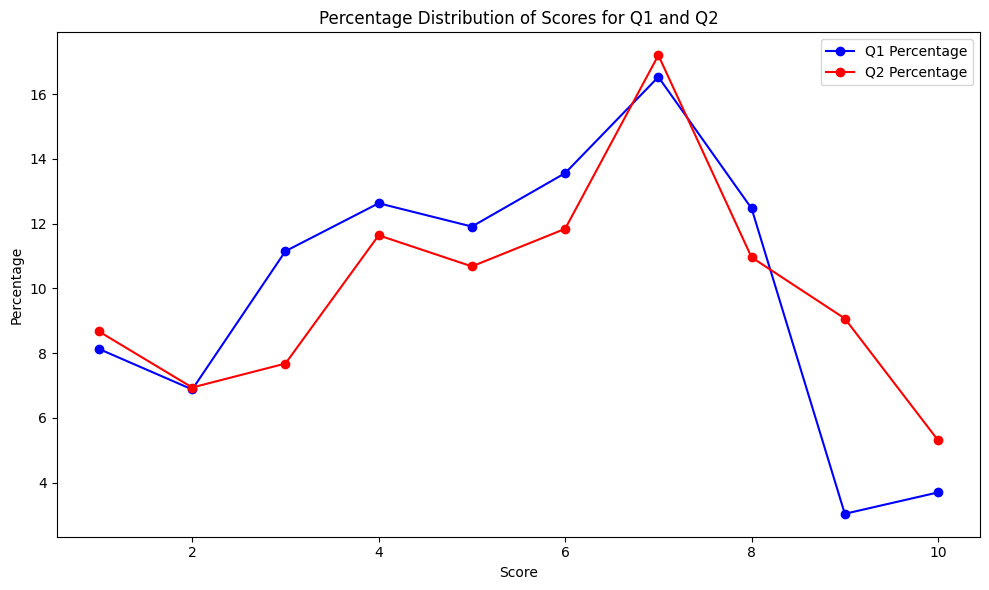

In [ ]:
q1_freq = df_q1['Score'].value_counts().sort_index()
q2_freq = df_q2['Score'].value_counts().sort_index()

# Calculate percentage distribution for Q1 and Q2
q1_percentage = ((q1_freq / q1_freq.sum()) * 100).round(2)
q2_percentage = ((q2_freq / q2_freq.sum()) * 100).round(2)

# Create DataFrames to store Score and Percentage
q1_distribution = pd.DataFrame({
    'Score': q1_percentage.index,
    'Percentage': q1_percentage.values
})

q2_distribution = pd.DataFrame({
    'Score': q2_percentage.index,
    'Percentage': q2_percentage.values
})

# Plotting the overlapping line chart
plt.figure(figsize=(10, 6))

# Line for Q1
plt.plot(q1_distribution['Score'], q1_distribution['Percentage'], marker='o', label='Q1 Percentage', color='blue')

# Line for Q2
plt.plot(q2_distribution['Score'], q2_distribution['Percentage'], marker='o', label='Q2 Percentage', color='red')

# Adding title and labels
plt.title('Percentage Distribution of Scores for Q1 and Q2')
plt.xlabel('Score')
plt.ylabel('Percentage')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Frequency distribution for 'Score' in Q2
print("\nFrequency distribution for 'Score' in Q2:")
# Calculate the frequency distribution
q2_freq = df_q2['Score'].value_counts().sort_index()

# Calculate percentage distribution
q2_percentage = ((q2_freq / q2_freq.sum()) * 100).round(2)

# Create a DataFrame to store the Score and Percentage
q2_distribution = pd.DataFrame({
    'Score': q2_percentage.index,
    'Percentage': q2_percentage.values
})

# Display the result
print(q2_distribution)


Frequency distribution for 'Score' in Q2:
   Score  Percentage
0      1        8.67
1      2        6.94
2      3        7.68
3      4       11.64
4      5       10.68
5      6       11.84
6      7       17.20
7      8       10.96
8      9        9.07
9     10        5.31


In [ ]:
# Analyzing 'Upvotes' column
print("\nDescriptive statistics for 'Upvotes' in the entire dataset:")
print(df['Upvotes'].describe())


Descriptive statistics for 'Upvotes' in the entire dataset:
count    375947.000000
mean         31.983447
std         779.473132
min        -484.000000
25%           1.000000
50%           2.000000
75%           3.000000
max      146172.000000
Name: Upvotes, dtype: float64


In [ ]:
# Analyzing content length
df['Content_Length'] = df['Content'].apply(lambda x: len(str(x).split()))
print("\nDescriptive statistics for 'Content_Length':")
print(df['Content_Length'].describe())



Descriptive statistics for 'Content_Length':
count    375947.000000
mean         23.375082
std          61.118390
min           1.000000
25%           3.000000
50%           9.000000
75%          23.000000
max        5965.000000
Name: Content_Length, dtype: float64


In [ ]:
# Most common subreddits
print("\nTop 10 most common subreddits:")
print(df['ContentSubreddit'].value_counts().head(10))


Top 10 most common subreddits:
ContentSubreddit
AskReddit              139559
teenagers               13235
memes                   11942
AskMen                   7944
unpopularopinion         6286
AskWomen                 3447
relationship_advice      3292
NoStupidQuestions        2620
AskOuija                 2474
AMA                      2272
Name: count, dtype: int64


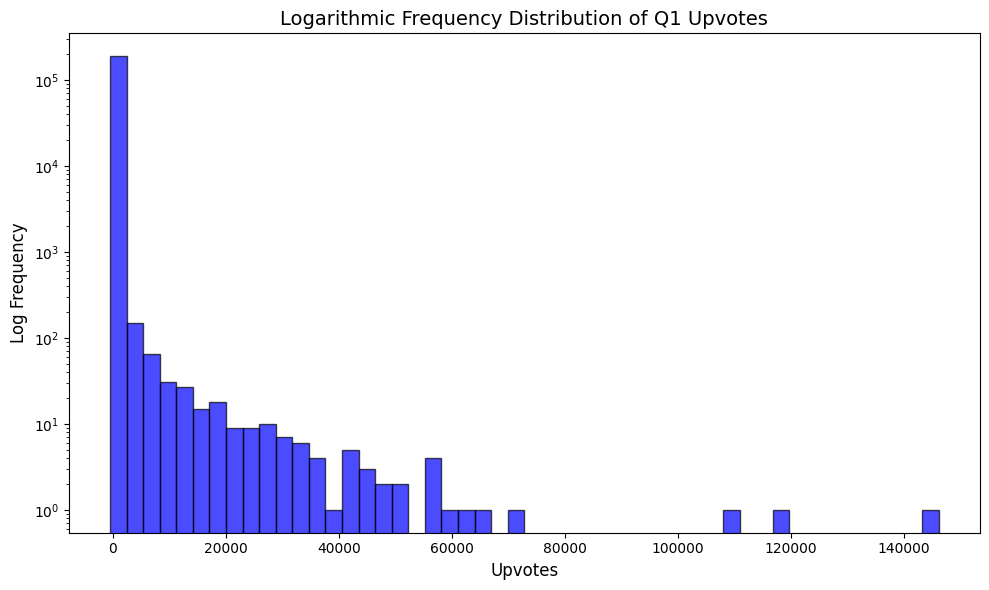

In [ ]:
# Plotting a histogram of the 'Upvotes' column with a log scale on the y-axis
plt.figure(figsize=(10, 6))
plt.hist(df_q1['Upvotes'], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')  # Applying logarithmic scale to the y-axis
plt.title('Logarithmic Frequency Distribution of Q1 Upvotes', fontsize=14)
plt.xlabel('Upvotes', fontsize=12)
plt.ylabel('Log Frequency', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

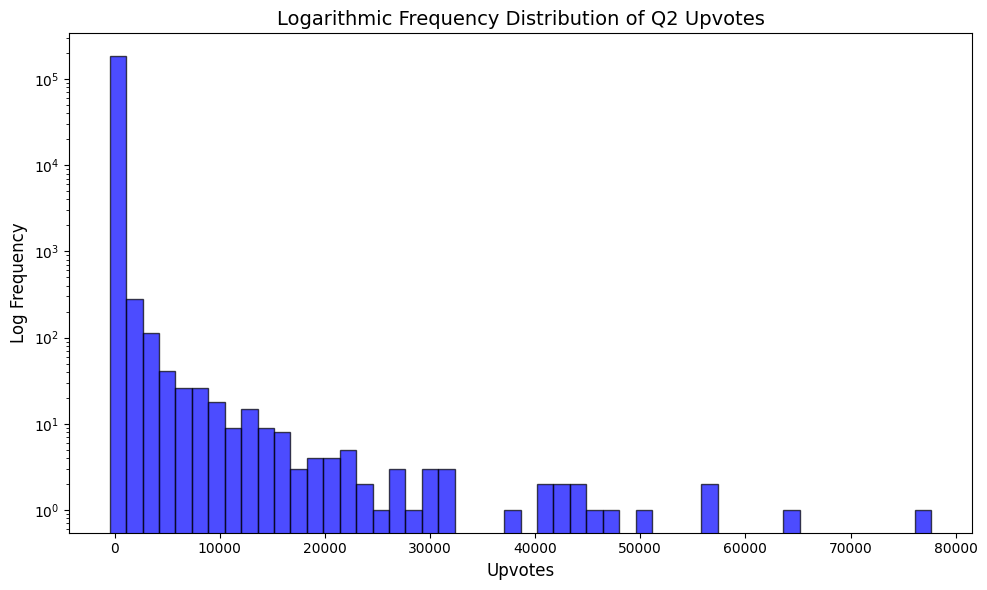

In [ ]:
# Plotting a histogram of the 'Upvotes' column with a log scale on the y-axis
plt.figure(figsize=(10, 6))
plt.hist(df_q2['Upvotes'], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')  # Applying logarithmic scale to the y-axis
plt.title('Logarithmic Frequency Distribution of Q2 Upvotes', fontsize=14)
plt.xlabel('Upvotes', fontsize=12)
plt.ylabel('Log Frequency', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

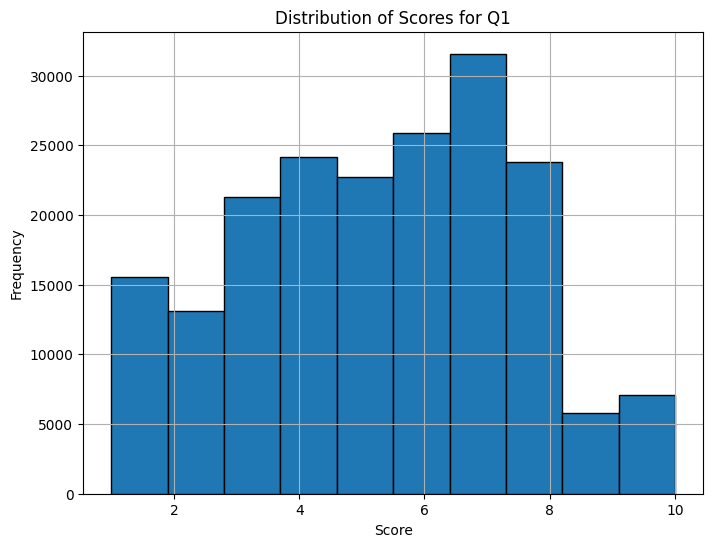

In [ ]:
# Histogram of 'Score' for Q1
plt.figure(figsize=(8,6))
df_q1['Score'].hist(bins=10, edgecolor='black')
plt.title('Distribution of Scores for Q1')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


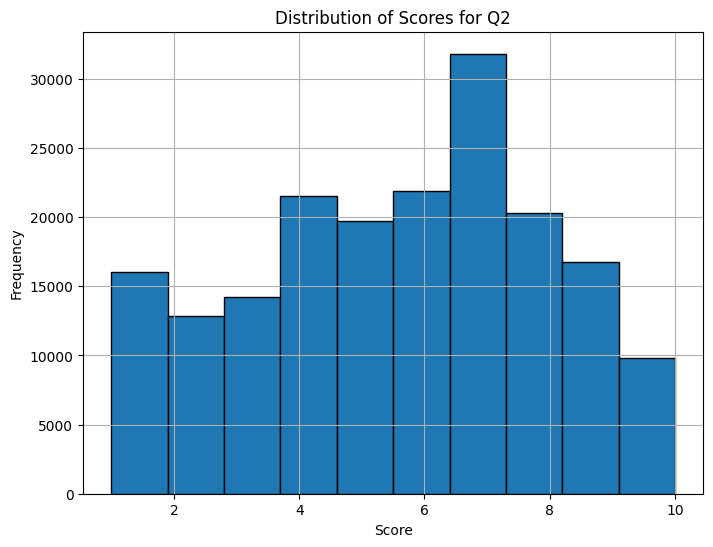

In [ ]:

# Histogram of 'Score' for Q2
plt.figure(figsize=(8,6))
df_q2['Score'].hist(bins=10, edgecolor='black')
plt.title('Distribution of Scores for Q2')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# 4. Check for missing values
print("\nMissing values in each column:")
df.isnull().sum()


Missing values in each column:


,0
Username,0
PostID,0
Type,0
Title,323262
Content,35002
ContentTimestamp,0
RelatedSubmissionID,0
ParentID,52685
IsSubmitter,0
ContentSubreddit,0


In [ ]:
# 4. Check for missing values
print("\nMissing values in each column of df_q1:")
df_q1.isnull().sum()


Missing values in each column of df_q1:


,0
Username,0
PostID,0
Type,0
Title,165010
Content,16334
ContentTimestamp,0
RelatedSubmissionID,0
ParentID,25991
IsSubmitter,0
ContentSubreddit,0


In [ ]:
# 4. Check for missing values
print("\nMissing values in each column of df_q2:")
df_q2.isnull().sum()


Missing values in each column of df_q2:


,0
Username,0
PostID,0
Type,0
Title,158252
Content,18668
ContentTimestamp,0
RelatedSubmissionID,0
ParentID,26694
IsSubmitter,0
ContentSubreddit,0


Number of unique usernames: 992


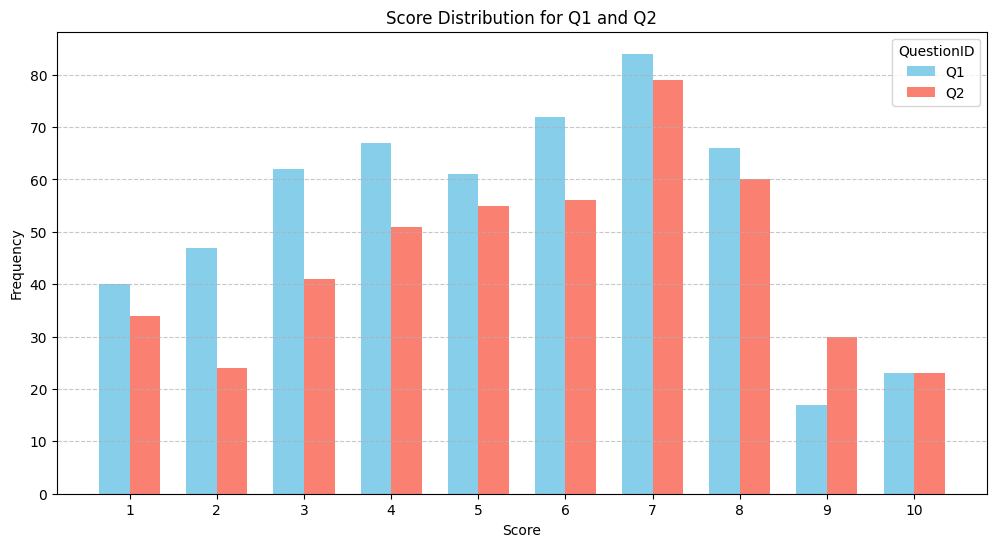

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def analyze_reddit_data(filename="RedditDataUTF-8.csv"):
    try:
        # Load the data, skipping bad lines if necessary
        df = pd.read_csv(filename, encoding='utf-8', on_bad_lines='skip')

        # Count the number of unique usernames
        unique_usernames_count = df['Username'].nunique()
        print(f"Number of unique usernames: {unique_usernames_count}")

        # Split data by QuestionID
        q1_df = df[df['QuestionID'] == 'Q1'].drop_duplicates(subset=['Username'])
        q2_df = df[df['QuestionID'] == 'Q2'].drop_duplicates(subset=['Username'])

        # Count the distribution of values in the 'Score' column for each QuestionID
        q1_scores = q1_df['Score'].value_counts().sort_index()
        q2_scores = q2_df['Score'].value_counts().sort_index()

        # Align the score distributions to have the same index (fill missing values with 0)
        score_index = sorted(set(q1_scores.index).union(set(q2_scores.index)))
        q1_scores = q1_scores.reindex(score_index, fill_value=0)
        q2_scores = q2_scores.reindex(score_index, fill_value=0)

        # Plot the distributions side by side
        bar_width = 0.35  # Width of the bars
        x = np.arange(len(score_index))  # the label locations

        plt.figure(figsize=(12, 6))
        plt.bar(x - bar_width/2, q1_scores, width=bar_width, color='skyblue', label='Q1')
        plt.bar(x + bar_width/2, q2_scores, width=bar_width, color='salmon', label='Q2')

        # Add labels, title, and legend
        plt.xlabel("Score")
        plt.ylabel("Frequency")
        plt.title("Score Distribution for Q1 and Q2")
        plt.xticks(x, score_index)  # Set the x-ticks to the score values
        plt.legend(title="QuestionID")  # Add a legend with a title
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.show()

    except pd.errors.ParserError as e:
        print("Parsing error encountered:", e)
analyze_reddit_data("RedditDataUTF-8.csv")